##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# American Option Pricing in TFF under the Black-Scholes Model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/American_Option_Black_Scholes.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/American_Option_Black_Scholes.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
#@title Upgrade to TensorFlow 2.5+
!pip install --upgrade tensorflow --user

In [ ]:
#@title Install TF Quant Finance
!pip install tf-quant-finance

     |████████████████████████████████| 1.4 MB 9.4 MB/s eta 0:00:01


In [ ]:
#@title Install QuantLib
!pip install QuantLib-Python

     |████████████████████████████████| 20.1 MB 7.2 MB/s eta 0:00:01


### This notebook demonstrates the use of low level Tensorflow Quant Finance tools for American Option pricing under the Black-Scholes model with emphasis on the following aspects:

  * **Batching**: Tensorflow is vectorized out of the box. Tensorflow Finance (TFF) written to leverage this wherever possible.
    * Most methods accept a "batch" of inputs.
  * **Hardware Accelerators**: Tensorflow supports GPUs without any code changes. Significant speedups with no code change.
    * Write the model once and run it on CPU or GPU.
    * Use XLA-compiler to improve performance. 

      **NB** PDE solvers rely on tridiagonal equation system solver. At the moment JIT compilation uses Thomas algorithm for all platforms (both CPUs and GPUs) so speed up from XLA compilation is only observed for CPU devices. 

The reported numbers below are obtained using standard Colab runtime on
[`n1-highmem-2`](https://cloud.google.com/compute/docs/general-purpose-machines#n1_machines) VM with `Tesla V100 GPU`




In [ ]:
# Get GPU info
!nvidia-smi

Fri Jul 16 14:09:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    38W / 300W |  15539MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get CPU info
!cat /proc/cpuinfo

In [ ]:
#@title **Imports** { display-mode: "form" }

import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns

import tensorflow as tf

# Import for Tensorflow Quant Finance
import tf_quant_finance as tff 

# Shortcut alias
pde = tff.math.pde

from IPython.core.pylabtools import figsize
figsize(21, 14)  # better graph size for Colab  

import QuantLib as ql


2021-07-16 13:33:18.352019: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


 ### Setup American Option pricer
   American option price $V(x, t)$ of an option with spot price $x$ at time $t$
   under Black-Scholes model satisfies the following PDE
   $$V_{t} + \frac{\sigma^2}{2}  x^2  V_{xx} + r  x  V_{x}
 - r  V(t, x) = 0.$$
  Tensorflow Quant Finance library provides tools for solving Parabolic PDE's
  of the form  
  $$V_{t} + \frac{a(t, x)}{2}  V_{xx} + b(t, x) V_{x} - c(t, x)  V = 0$$

  Henceforth,
  $a(t, x)$, $b(t, x)$, and $c(t, x)$ are referred to as quadratic, linear and
  shift coefficients, respectively. We describe in details how to write a
  custom pricer that is both batchable (i.e., multiple equations can be solved
  simultaneously) and compatible with an NVIDIA GPU. 


In [ ]:
#@title **American Option pricer**

# tf.function decorator makes the function faster in graph mode.
@tf.function
def american_option(number_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    expiry,
                    dtype=tf.float64):
  """ Computes American Call options prices.

  Args:
    number_grid_points: A Python int. Number of grid points for the finite
      difference scheme.
    time_delta: A Python float. Grid time discretization parameter.
    strike: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the strikes of the underlying American options. 
    volatility: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the volatilities of the underlying American options. 
    risk_free_rate: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the risk-free interest rates associated with the underlying
      American options.
    expiry: A Python float. Expiry date of the options. If the options
      have different expiries, volatility term has to adjusted to
      make expiries the same.
    dtype: Optional `tf.dtype` used to assert dtype of the input `Tensor`s.

  Returns:
    A tuple of the estimated option prices of shape
    `(number_of_options, number_grid_points)` and the corresponding `Tensor` 
    of grid locations of shape `(number_grid_points,)`.
  """
  # Define the coordinate grid
  s_min = 0.01
  s_max = 300.
  grid = pde.grids.uniform_grid(minimums=[s_min],
                                maximums=[s_max],
                                sizes=[number_grid_points],
                                dtype=dtype)

  # Define the values grid for the final condition
  s = grid[0]
  final_values_grid = tf.nn.relu(s - strike)

  # Define the PDE coefficient functions
  def second_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [[volatility ** 2 * s ** 2 / 2]]

  def first_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [risk_free_rate * s]

  def zeroth_order_coeff_fn(t, grid):
    del t, grid
    return -risk_free_rate

  # Define the boundary conditions
  @pde.boundary_conditions.dirichlet
  def lower_boundary_fn(t, grid):
    del t, grid
    return tf.constant(0.0, dtype=dtype)

  @pde.boundary_conditions.dirichlet
  def upper_boundary_fn(t, grid):
    del grid
    return tf.squeeze(s_max - strike * tf.exp(-risk_free_rate * (expiry - t)))

  # In order to price American option one needs to set option values to 
  # V(x) := max(V(x), max(x - strike, 0)) after each iteration
  def values_transform_fn(t, grid, values):
    del t
    s = grid[0]
    values_floor = tf.nn.relu(s - strike)
    return grid, tf.maximum(values, values_floor)

  # Solve
  estimate_values, estimate_grid, _, _ = \
    pde.fd_solvers.solve_backward(
      start_time=expiry,
      end_time=0,
      values_transform_fn=values_transform_fn,
      coord_grid=grid,
      values_grid=final_values_grid,
      time_step=time_delta,
      boundary_conditions=[(lower_boundary_fn, upper_boundary_fn)],
      second_order_coeff_fn=second_order_coeff_fn,
      first_order_coeff_fn=first_order_coeff_fn,
      zeroth_order_coeff_fn=zeroth_order_coeff_fn,
      dtype=dtype
    )
  return estimate_values, estimate_grid[0]


def option_param(number_of_options, dtype, seed=42):
  """ Function to generate volatilities, rates, strikes """
  np.random.seed(seed)
  if number_of_options > 1:
    volatility = tf.random.uniform(shape=(number_of_options, 1),
                                   dtype=dtype) * 0.1 + 0.3
    # Random risk free rate between 0 and 0.2.
    risk_free_rate = tf.constant(
      np.random.rand(number_of_options, 1) * 0.05, dtype)
    # Random strike between 20 and 120.
    strike = tf.constant(
      np.random.rand(number_of_options, 1) * 100 + 50, dtype)
  else:
    volatility = tf.constant([0.3], dtype)
    risk_free_rate = tf.constant([0.05], dtype)
    strike = tf.constant([50], dtype)
  return volatility, risk_free_rate, strike

### Batching

* Batching is a powerful feature of design of Tensorflow.
* TFF leverages this strongly.
* Most methods can accept a "batch" of inputs.
* Example below (Batch of American Call Options with varying strikes, vols and rates).



In [ ]:
#@title Price multiple American Call options at a time

number_of_options = 10 #@param

time_delta = 0.005

expiry = 1.0  

number_grid_points = 1024 

dtype = tf.float64 

spot = 110  + tf.random.uniform(shape=[number_of_options, 1], dtype=dtype)

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

# Build a graph to compute prices of the American Options.
estimate, grid_locations = american_option(
    time_delta=time_delta,
    expiry=expiry,
    number_grid_points=number_grid_points,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    strike=strike,
    dtype=dtype)

# Convert to numpy for plotting
estimate = estimate.numpy()
grid_locations = grid_locations.numpy()

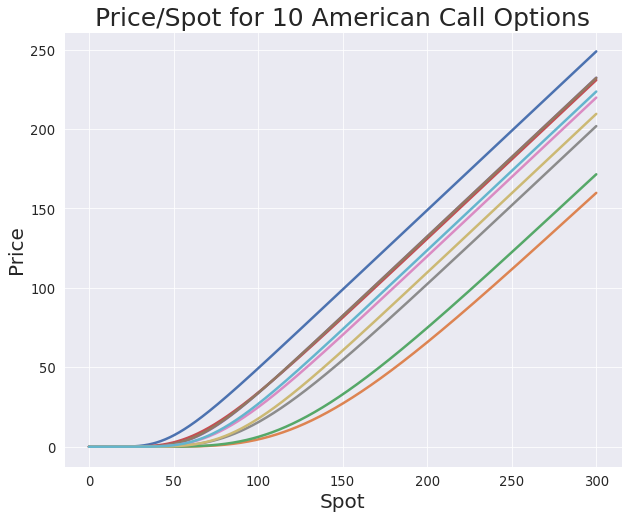

In [ ]:
#@title Price/spot plot for the American Call options
# Prepare data for plotting 
options = [x + 1 for x in range(number_of_options) for _ in range(1024)]
plot_data = pd.DataFrame({
    'Spot': list(np.ndarray.flatten(grid_locations)) * number_of_options, 
    'Price': estimate.flatten(),
    'Option': options})


# Plot
plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plot = sns.lineplot(x="Spot", y="Price", hue="Option",
                    data=plot_data,
                    palette=sns.color_palette()[:number_of_options],
                    legend=False)
plot.axes.set_title(f"Price/Spot for {number_of_options} American Call Options",
                    fontsize=25)
xlabel = plot.axes.get_xlabel()
ylabel = plot.axes.get_ylabel()
plot.axes.set_xlabel(xlabel, fontsize=20)
plot.axes.set_ylabel(ylabel, fontsize=20)
plt.show()

### Speedup from batching and XLA-compilation

* Note that GPUs are particularly good for vectorized calculations. 
* XLA compilation (in this case Just-in-time compilation) improves CPU performance and demonstrates performance advantage over QuantLib.

In [ ]:
#@title Tensorflow Finance pricing on GPU

number_of_options = 10000  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = tf.float64

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

device = "/gpu:0"
with tf.device(device):
  
  # Warmup (graph construction + graph optimization)
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

  # Timed run
  t = time.time()
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)
  time_gpu = time.time() - t
    
gpu_options_per_second = number_of_options / time_gpu
print('------------------------')
print('Tensorflow GPU')
print('wall time: ', time_gpu)
print('options per second: ', gpu_options_per_second)
print('------------------------')

------------------------
Tensorflow GPU
wall time:  3.161587953567505
options per second:  3162.967517230099
------------------------


In [ ]:
#@title Tensorflow Finance pricing on CPU

number_of_options = 50  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = tf.float64

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

device = "/cpu:0"
with tf.device(device):
  
  # Warmup (graph construction + graph optimization + jit_compilation)
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

  # Timed run
  t = time.time()
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)
  time_cpu = time.time() - t

cpu_options_per_second = number_of_options / time_cpu
print('Tensorflow CPU')
print('wall time: ', time_cpu)
print('options per second: ', cpu_options_per_second)
print('------------------------')

Tensorflow CPU
wall time:  0.7148475646972656
options per second:  69.94498193635835
------------------------


In [ ]:
#@title Tensorflow Finance pricing on CPU (with XLA-compiled compuation)

number_of_options = 50  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = tf.float64

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

american_option_xla = tf.function(american_option, 
                                  jit_compile=True)
device = "/cpu:0"
with tf.device(device):
  
  # Warmup (graph construction + graph optimization)
  estimate, _ = american_option_xla(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

  # Timed run
  t = time.time()
  estimate, _ = american_option_xla(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)
  time_cpu = time.time() - t

cpu_jit_options_per_second = number_of_options / time_cpu
print('Tensorflow CPU XLA')
print('wall time: ', time_cpu)
print('options per second: ', cpu_jit_options_per_second)
print('------------------------')

Tensorflow CPU XLA
wall time:  0.2038886547088623
options per second:  245.2318892946557
------------------------


In [ ]:
#@title Quantlib  pricing

# Will run only if QuantLib is installed

number_of_options = 50  #@param

dtype = tf.float64

volatilities, risk_free_rates, strikes = option_param(number_of_options, dtype)

(
    volatilities, risk_free_rates, strikes
 ) = (volatilities.numpy(), 
      risk_free_rates.numpy(),
      strikes.numpy()) 

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

spot_quote = ql.SimpleQuote(0.0)
strike_quote = ql.SimpleQuote(0.0)
rate_quote = ql.SimpleQuote(0.0)
vol_quote = ql.SimpleQuote(0.0)

# Initializers for American option pricer inputs
spot_handle = ql.QuoteHandle(spot_quote)
strike_handle = ql.QuoteHandle(strike_quote)
rate_handle = ql.QuoteHandle(rate_quote)
vol_handle = ql.QuoteHandle(vol_quote)


calculation_date = ql.Date(1, 1, 2010)
maturity_date = ql.Date(1, 1, 2011)
day_count = ql.Thirty360()
calendar = ql.NullCalendar()

option_type = ql.Option.Call

# Create American option data
ql.Settings.instance().evaluationDate = calculation_date

am_exercise = ql.AmericanExercise(calculation_date, maturity_date)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, rate_handle, day_count)
)

flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, vol_handle, day_count)
)


bsm_process = ql.BlackScholesProcess(spot_handle,
                                      flat_ts,
                                      flat_vol_ts)
# Compute the same price number_of_options times for fair time comparison
t = time.time()
for vol, rate, strike in zip(volatilities, risk_free_rates, strikes): 
  strike_quote.setValue(strike[0])
  spot_quote.setValue(strike[0])
  rate_quote.setValue(rate[0])
  vol_quote.setValue(vol[0])
  fd_american_engine = ql.FdBlackScholesVanillaEngine(
      bsm_process,
      int(expiry / time_delta),
      number_grid_points)
  payoff = ql.PlainVanillaPayoff(option_type, strike[0])
  # Create American option object
  american_option_ql = ql.VanillaOption(payoff, am_exercise)
  american_option_ql.setPricingEngine(fd_american_engine)
  # Price calculation
  price = american_option_ql.NPV()

time_ql = time.time() - t

ql_options_per_second = number_of_options / time_ql
print('------------------------')
print('QuantLib')
print('wall time: ', time_ql)
print('options per second: ', ql_options_per_second)
print('------------------------')

------------------------
QuantLib
wall time:  0.8111381530761719
options per second:  61.64178051590754
------------------------


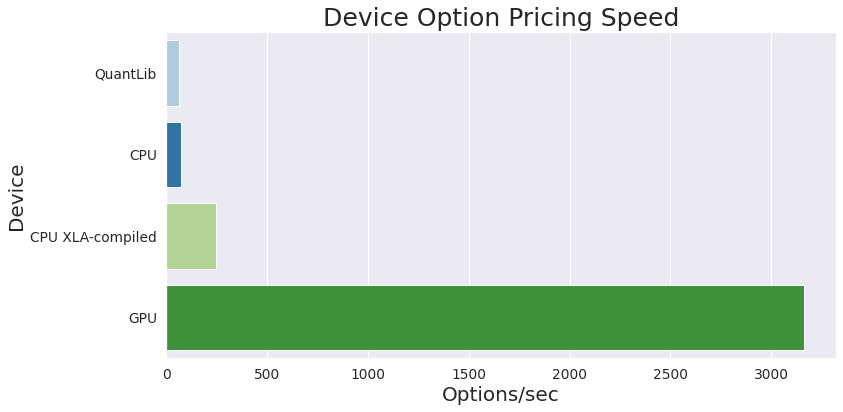

In [ ]:
#@title Tensorflow Finance vs QuantLib
# Throughput
times_pd = pd.DataFrame([('QuantLib', ql_options_per_second), 
                         ('CPU', cpu_options_per_second),
                         ('CPU XLA-compiled', cpu_jit_options_per_second), 
                         ('GPU', gpu_options_per_second)],
                         columns=['Device', 'Options/sec'])
sns.set(style="darkgrid", palette="Paired")
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 6))
pt = sns.barplot(y="Device", x="Options/sec", data=times_pd)
pt.axes.set_title("Device Option Pricing Speed", fontsize=25)
xlabel = pt.axes.get_xlabel()
ylabel = pt.axes.get_ylabel()
pt.axes.set_xlabel(xlabel, fontsize=20)
pt.axes.set_ylabel(ylabel, fontsize=20)
plt.show()

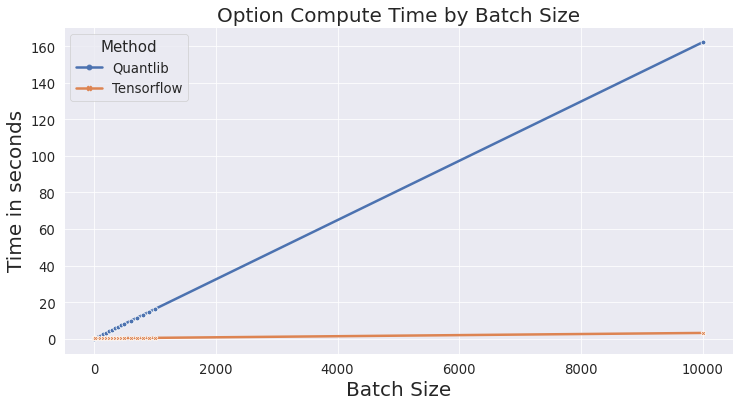

In [ ]:
#@title Time to price a batch of options (GPU vs QuantLib)

import matplotlib.pyplot as plt
import numpy as np
import time
batch_of_options = [1, 10, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 10000]  #@param

gpu_times = []
cpu_times = []


for options in batch_of_options:
    
  # Generate volatilities, rates, strikes
  volatility, risk_free_rate, strike = option_param(options, dtype)

  with tf.device("/gpu:0"):
    
    # Warmup
    estimate, _ = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    
    # Timed run
    t = time.time()
    estimate, _ = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    time_gpu = time.time() - t
    
  gpu_times.append(time_gpu)

# We hardcode QunatLib values here for simplicity
ql_times = [1 / ql_options_per_second * i for i in batch_of_options]

# Prepare Plotting 
plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
batches = batch_of_options * 2
num_batches = len(batch_of_options)
method = ["Quantlib"] * num_batches +  ["Tensorflow"] * num_batches
times = ql_times + gpu_times
data = {"Batch Size": batches,
        "Method": method,
        "Times": times}
ql_gpu_times = pd.DataFrame(data = data)
plot = sns.lineplot(x="Batch Size", y="Times", hue="Method", style = "Method",
                    data=ql_gpu_times, markers=True, dashes=False)
#handles, labels = plot.get_legend_handles_labels()
#plot.legend(handles=handles[1:], labels=labels[1:], loc="upper left")
plot.axes.set_title("Option Compute Time by Batch Size", fontsize=20)
xlabel = plot.axes.get_xlabel()
plot.axes.set_xlabel(xlabel, fontsize=20)
plot.axes.set_ylabel('Time in seconds', fontsize=20)
plt.setp(plot.get_legend().get_title(), fontsize=15)
plt.show()

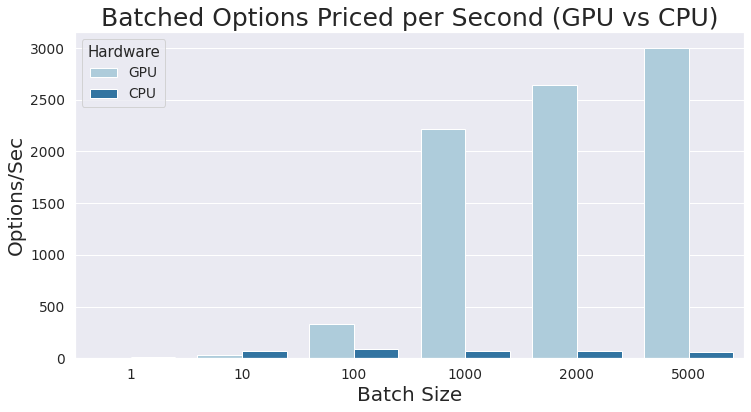

In [ ]:
#@title Options per second depending on the batch size

batch_of_options = [1, 10, 100, 1000, 2000, 5000]  #@param
gpu_times = []
cpu_times = []

for options in batch_of_options:
    
  with tf.device("/gpu:0"):
        
    # Generate volatilities, rates, strikes
    volatility, risk_free_rate, strike = option_param(options, dtype)
    
    # Warmup
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    
    # Timed run
    t = time.time()
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    time_gpu = time.time() - t

  gpu_times.append(options / time_gpu)

for options in batch_of_options:

  with tf.device("/cpu:0"):
        
    # Generate volatilities, rates, strikes
    volatility, risk_free_rate, strike = option_param(options, dtype)
    
    # Warmup
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    
    # Timed run
    t = time.time()
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    time_cpu = time.time() - t
    
  cpu_times.append(options / time_cpu)

# Prepare data for plotting
plt.figure(figsize=(12, 6))
batches = batch_of_options * 2
num_batches = len(batch_of_options)
method = ["GPU"] * num_batches +  ["CPU"] * num_batches
times = gpu_times + cpu_times
data = {"Batch Size": batches,
        "Hardware": method,
        "Options/Sec": times}
gpu_cpu_times = pd.DataFrame(data = data)
sns.set(style="darkgrid", palette="Paired")
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
pt = sns.barplot(x="Batch Size", y="Options/Sec",hue="Hardware", data=gpu_cpu_times)
pt.axes.set_title("Batched Options Priced per Second (GPU vs CPU)",fontsize=25)
xlabel = pt.axes.get_xlabel()
ylabel = pt.axes.get_ylabel()
pt.axes.set_xlabel(xlabel, fontsize=20)
pt.axes.set_ylabel(ylabel, fontsize=20)
plt.show()